In [523]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import linalg
from scipy.integrate import odeint

## Lorenz System Generator

In [524]:
def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

/var/folders/_3/tfhkx2td6f7c95jqlc4nf8l80000gn/T/ipykernel_906/1897184520.py:15: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


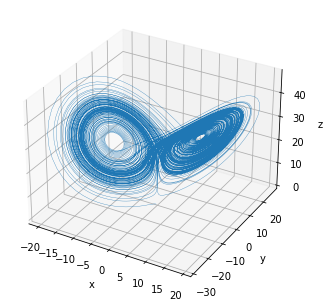

In [525]:
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
#timestep = 0.01  # typical time difference mentioned in Shimada&Nagashima(1979)
timestep = 0.01
size = 16000

np.random.seed(1221515)
state0 = np.random.uniform(-1,1,(3)).tolist()
t = np.arange(0.0, timestep*size, timestep)

states = odeint(f, state0, t)
np.savetxt('Lorenz.txt',states)
fig = plt.figure()
ax = Axes3D(fig)
#ax = fig.gca(projection="3d")
ax.plot(states[:, 0], states[:, 1], states[:, 2], linewidth=0.3)
ax.xaxis.set_label_text('x')
ax.yaxis.set_label_text('y')
ax.zaxis.set_label_text('z')
plt.draw()
plt.show()

## ESN

In [526]:
np.random.seed(0)

In [527]:
# load the data
data = np.loadtxt('Lorenz.txt')
u = data[:, :] # input
y = data[1:, :] # output

In [528]:
# hyperparameters
trainLen = 3000
testLen = 500
initLen = 500 # washout phase
rho = 0.9 # spectral radius
sigma = 0.5 # input scale
lamda = 1e-7 # coefficient of regularization
inSize = outSize = 3
resSize = 500

# # hyperparameters
# trainLen = 2000
# testLen = 500
# initLen = 100 # washout phase
# rho = 0.9 # spectral radius
# sigma = 0.8 # input scale
# lamda = 1e-8 # coefficient of regularization
# inSize = outSize = 3
# resSize = 100

In [529]:
np.random.seed(41251)
Win = (np.random.rand(resSize,1+inSize) - 0.5) * 2 * sigma
W = np.random.rand(resSize, resSize) - 0.5
W=W/max(abs(linalg.eig(W)[0]))*rho

In [530]:
X = np.zeros((1+inSize+resSize, trainLen))
Yt = y[None, initLen:trainLen+initLen].squeeze().T

In [531]:
# run the reservoir with the data and collect X
x = np.zeros((resSize, 1))
for t in range(trainLen+initLen):
    u_current = u[t].reshape(-1,1)
    x = np.tanh(np.dot(Win, np.vstack((1, u_current))) + np.dot(W, x))
    if t >= initLen:
        X[:, t-initLen] = np.vstack((1, u_current, x))[:, 0].reshape(resSize+inSize+1)

In [532]:
Wout = np.dot(np.dot(Yt,X.T), linalg.inv(np.dot(X,X.T) + lamda*np.eye(1+inSize+resSize)))

In [533]:
Y = np.zeros((outSize, testLen))
u_current = u[trainLen+initLen-1].reshape(-1,1)
for t in range(testLen):
    #u_current = u[trainLen+initLen+t].reshape(-1,1)
    x = np.tanh(np.dot(Win, np.vstack((1, u_current))) + np.dot(W, x))
    u_current = np.dot(Wout, np.vstack((1, u_current, x))).squeeze()
    Y[:, t] = u_current
    u_current = Y[:, t].reshape(-1,1) # closed loop

In [534]:
errorLen = testLen
nmse = sum(np.square(y[trainLen+initLen+1:trainLen+initLen+errorLen+1] - Y[:, 0:errorLen].T)) / errorLen / np.std(y[trainLen+initLen+1:trainLen+initLen+errorLen+1]) / np.std(y[trainLen+initLen+1:trainLen+initLen+errorLen+1])
print('nmse:',nmse)

nmse: [0.20131496 0.26915682 0.14568484]


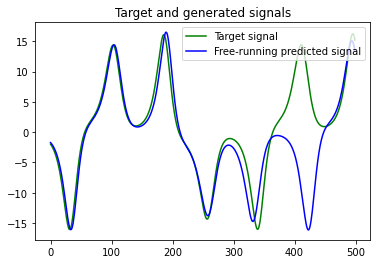

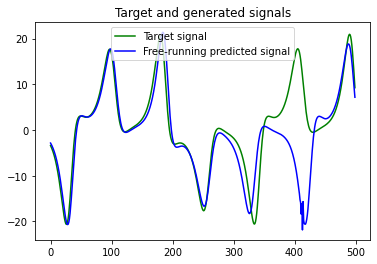

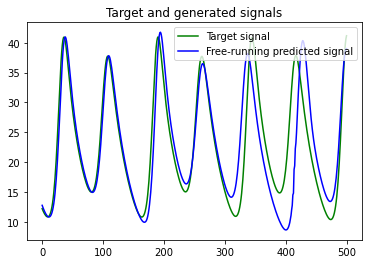

In [535]:
# plot some signals
for i in range(inSize):
    plt.figure(1).clear()
    plt.plot(y[trainLen+initLen+1:trainLen+initLen+testLen+1, i], 'g')
    plt.plot(Y.T[:, i], 'b')
    plt.title('Target and generated signals')
    plt.legend(['Target signal', 'Free-running predicted signal'])
    plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2728d440-5ff4-4e65-a400-4cda139b052c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>